# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfl
import pandas as pd
import zipfile

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Loading Data

In [2]:
with zipfile.ZipFile('/kaggle/input/facial-keypoints-detection/training.zip', 'r') as zip_ref:
    zip_ref.extractall()
with zipfile.ZipFile('/kaggle/input/facial-keypoints-detection/test.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [3]:
train_data_df = pd.read_csv('training.csv')
test_data_df = pd.read_csv('test.csv')

# Describing Data

In [4]:
train_data_df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [5]:
test_data_df.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [6]:
pd.Series(train_data_df.columns)

0             left_eye_center_x
1             left_eye_center_y
2            right_eye_center_x
3            right_eye_center_y
4       left_eye_inner_corner_x
5       left_eye_inner_corner_y
6       left_eye_outer_corner_x
7       left_eye_outer_corner_y
8      right_eye_inner_corner_x
9      right_eye_inner_corner_y
10     right_eye_outer_corner_x
11     right_eye_outer_corner_y
12     left_eyebrow_inner_end_x
13     left_eyebrow_inner_end_y
14     left_eyebrow_outer_end_x
15     left_eyebrow_outer_end_y
16    right_eyebrow_inner_end_x
17    right_eyebrow_inner_end_y
18    right_eyebrow_outer_end_x
19    right_eyebrow_outer_end_y
20                   nose_tip_x
21                   nose_tip_y
22          mouth_left_corner_x
23          mouth_left_corner_y
24         mouth_right_corner_x
25         mouth_right_corner_y
26       mouth_center_top_lip_x
27       mouth_center_top_lip_y
28    mouth_center_bottom_lip_x
29    mouth_center_bottom_lip_y
30                        Image
dtype: o

In [7]:
pd.Series(test_data_df.columns)

0    ImageId
1      Image
dtype: object

In [8]:
print(train_data_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

In [9]:
print(test_data_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1783 entries, 0 to 1782
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImageId  1783 non-null   int64 
 1   Image    1783 non-null   object
dtypes: int64(1), object(1)
memory usage: 28.0+ KB
None


In [10]:
for col in train_data_df.columns.tolist():          
    print('{} column missing values: {}'.format(col, train_data_df[col].isnull().sum()))

left_eye_center_x column missing values: 10
left_eye_center_y column missing values: 10
right_eye_center_x column missing values: 13
right_eye_center_y column missing values: 13
left_eye_inner_corner_x column missing values: 4778
left_eye_inner_corner_y column missing values: 4778
left_eye_outer_corner_x column missing values: 4782
left_eye_outer_corner_y column missing values: 4782
right_eye_inner_corner_x column missing values: 4781
right_eye_inner_corner_y column missing values: 4781
right_eye_outer_corner_x column missing values: 4781
right_eye_outer_corner_y column missing values: 4781
left_eyebrow_inner_end_x column missing values: 4779
left_eyebrow_inner_end_y column missing values: 4779
left_eyebrow_outer_end_x column missing values: 4824
left_eyebrow_outer_end_y column missing values: 4824
right_eyebrow_inner_end_x column missing values: 4779
right_eyebrow_inner_end_y column missing values: 4779
right_eyebrow_outer_end_x column missing values: 4813
right_eyebrow_outer_end_y co

In [11]:
train_data_df[train_data_df['left_eye_center_x'].isnull()]

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
1687,NaN,NaN,NaN,NaN,57.931068,40.808627,73.232712,44.910035,NaN,NaN,...,55.500993,54.595918,74.511943,24.118659,68.652754,39.136317,71.487238,37.405514,75.520178,53 55 55 56 57 58 60 62 63 64 65 66 69 71 72 6...
1834,NaN,NaN,NaN,NaN,41.122383,43.111925,49.822688,39.401949,28.818827,47.168082,...,63.240190,54.380973,63.966847,31.776519,74.325852,37.135567,70.228468,41.736649,76.507387,68 68 69 68 68 70 67 68 73 70 70 70 71 70 69 7...
1866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,53.877310,57.458039,80.878314,32.511208,76.078956,45.435075,76.046196,44.288471,79.993791,25 23 23 22 21 21 21 19 21 25 25 19 17 14 21 2...
1938,NaN,NaN,NaN,NaN,59.603142,41.750697,75.085986,49.088207,38.232536,33.229570,...,62.884158,49.917692,82.619275,21.997412,69.704035,35.746465,78.990190,34.873289,81.526558,42 41 44 47 49 44 42 42 41 42 42 44 45 50 44 4...
2100,NaN,NaN,46.180446,38.001579,67.601641,41.736941,77.647986,42.364153,50.589530,38.493913,...,60.458789,66.114101,75.403698,39.672788,73.862758,55.859308,71.557480,52.268891,84.015333,35 16 26 31 56 33 18 25 39 71 96 113 101 62 50...
2137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,51.613917,54.875576,67.435945,37.504147,60.976959,44.479263,60.917972,45.482028,68.394470,17 17 16 16 16 14 15 15 15 15 15 14 14 16 16 1...
2153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,53.724863,63.036965,68.311584,37.544582,70.934866,52.036102,69.475137,52.268813,70.702156,45 51 64 51 46 61 66 61 62 60 58 60 67 73 82 8...
2175,NaN,NaN,66.786621,39.081633,NaN,NaN,NaN,NaN,70.714966,38.542177,...,50.219898,NaN,NaN,74.017993,68.806327,83.989082,66.173401,84.979218,67.902653,0 0 1 0 0 1 0 1 2 2 2 2 2 2 4 4 3 4 3 4 3 5 5 ...
2186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,57.979672,73.062903,68.390158,NaN,NaN,49.711997,71.270341,50.830746,77.197330,178 176 174 168 159 154 150 144 135 124 95 70 ...
2239,NaN,NaN,31.925567,35.312088,57.229069,39.959582,NaN,NaN,38.241712,38.002787,...,55.102877,58.146540,71.447188,32.288900,69.744848,46.050971,72.038527,46.033051,73.830463,5 7 7 12 24 53 87 81 67 87 113 129 113 115 130...


In [12]:
train_data_df[train_data_df['left_eye_inner_corner_x'].isnull()]

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
1654,66.983855,37.191636,30.778167,27.431834,NaN,NaN,76.579801,40.116137,38.349460,30.472663,...,54.676425,60.910345,70.723153,18.179873,60.403659,41.001999,67.490500,38.801970,73.222801,105 114 137 137 127 103 87 127 165 60 47 36 56...
1685,65.153204,39.850963,30.073522,40.311816,NaN,NaN,72.418622,40.836359,NaN,NaN,...,59.520387,66.747711,81.967816,32.127888,84.451582,50.412462,81.977636,49.874749,83.356986,236 238 239 238 238 246 185 138 165 163 161 16...
1738,64.698292,41.840302,30.664127,39.857899,NaN,NaN,72.205593,42.196825,38.008889,40.258927,...,55.656740,57.720067,82.036922,27.478519,80.292668,44.365134,79.399571,43.650491,81.742101,67 80 93 92 104 100 118 110 75 64 53 37 38 39 ...
1742,59.419060,39.825120,32.745235,37.487248,NaN,NaN,NaN,NaN,37.991639,38.536529,...,58.465766,57.688098,75.699000,36.233064,74.628681,44.034717,74.072115,44.519929,75.407095,41 41 42 40 44 43 41 40 38 39 39 32 31 29 25 2...
1866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,53.877310,57.458039,80.878314,32.511208,76.078956,45.435075,76.046196,44.288471,79.993791,25 23 23 22 21 21 21 19 21 25 25 19 17 14 21 2...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7044,67.402546,31.842551,29.746749,38.632942,NaN,NaN,NaN,NaN,NaN,NaN,...,67.029093,NaN,NaN,NaN,NaN,NaN,NaN,50.426637,79.683921,71 74 85 105 116 128 139 150 170 187 201 209 2...
7045,66.134400,38.365501,30.478626,39.950198,NaN,NaN,NaN,NaN,NaN,NaN,...,66.626011,NaN,NaN,NaN,NaN,NaN,NaN,50.287397,77.983023,60 60 62 57 55 51 49 48 50 53 56 56 106 89 77 ...
7046,66.690732,36.845221,31.666420,39.685042,NaN,NaN,NaN,NaN,NaN,NaN,...,67.515161,NaN,NaN,NaN,NaN,NaN,NaN,49.462572,78.117120,74 74 74 78 79 79 79 81 77 78 80 73 72 81 77 1...
7047,70.965082,39.853666,30.543285,40.772339,NaN,NaN,NaN,NaN,NaN,NaN,...,66.724988,NaN,NaN,NaN,NaN,NaN,NaN,50.065186,79.586447,254 254 254 254 254 238 193 145 121 118 119 10...


# Splitting data to train, test, and labels

In [13]:
def process_data(data_df,train):
    if train:
        y=np.array(data_df.iloc[:,:30])

    img_dt = []
    for i in range(len(data_df)):
        img_dt.append(data_df['Image'][i].split(' '))

    X=np.array(img_dt, dtype='float')
    return X,y if train else " "

In [14]:
X_train,y_train=process_data(train_data_df,True)
X_test_submit,_=process_data(test_data_df,False)

In [15]:
print(X_train)
print(y_train)
print(X_test_submit)

[[238. 236. 237. ...  70.  75.  90.]
 [219. 215. 204. ...   1.   1.   1.]
 [144. 142. 159. ...  78.  78.  77.]
 ...
 [ 74.  74.  74. ...  20.  20.  20.]
 [254. 254. 254. ... 254. 254. 254.]
 [ 53.  62.  67. ... 158. 158. 159.]]
[[66.03356391 39.00227368 30.22700752 ... 72.93545865 43.13070677
  84.48577444]
 [64.33293617 34.9700766  29.9492766  ... 70.26655319 45.46791489
  85.48017021]
 [65.05705263 34.90964211 30.90378947 ... 70.19178947 47.27494737
  78.65936842]
 ...
 [66.69073171 36.84522146 31.66641951 ...         nan 49.46257171
  78.11712   ]
 [70.96508235 39.85366588 30.54328471 ...         nan 50.06518588
  79.58644706]
 [66.93831111 43.42450963 31.09605926 ...         nan 45.90048
  82.7730963 ]]
[[182. 183. 182. ...   8.   5.   5.]
 [ 76.  87.  81. ... 228. 211. 168.]
 [177. 176. 174. ...   1.   1.   1.]
 ...
 [ 28.  28.  29. ...  77.  78.  78.]
 [104.  95.  71. ... 144. 151. 159.]
 [ 63.  61.  64. ... 113. 112. 113.]]


# Fixing null values

In [16]:
from sklearn.impute import SimpleImputer
imputer=SimpleImputer(missing_values=np.nan, strategy='mean')

for i in range(30):
    imputer.fit(y_train[:,i].reshape(-1,1))
    y_train[:,i]=(imputer.transform(y_train[:,i].reshape(-1,1))).reshape(-1,)

In [17]:
print(y_train[556,0])
print(y_train[2239,0])
print(y_train[1600,4])
print(y_train[1654,4])

65.7826242038
66.35902124475365
59.336079734
59.15933943740387


In [18]:
print(X_train.shape)
print(y_train.shape)
print(X_test_submit.shape)

(7049, 9216)
(7049, 30)
(1783, 9216)


In [19]:
X_train=X_train.reshape(X_train.shape[0],96,96)
X_test_submit=X_test_submit.reshape(X_test_submit.shape[0],96,96)

# Exploring Data

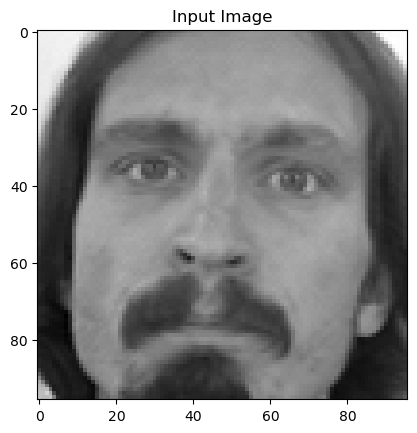

In [20]:
plt.imshow(X_train[0], cmap='gray')
plt.title("Input Image")
plt.savefig('plot.png', bbox_inches='tight')
plt.show()

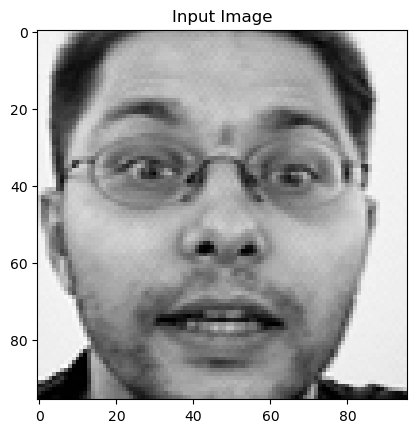

In [21]:
plt.imshow(X_test_submit[0], cmap='gray')
plt.title("Input Image")
plt.savefig('plot.png', bbox_inches='tight')
plt.show()

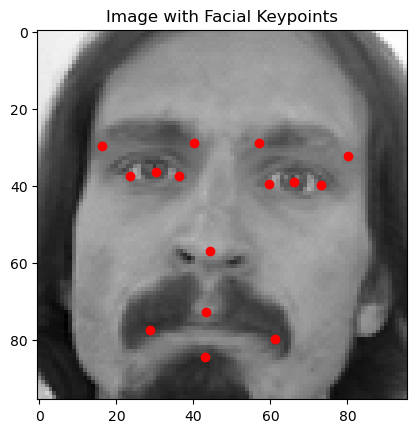

In [22]:
plt.imshow(X_train[0], cmap='gray')
plt.scatter(y_train[0][0::2], y_train[0][1::2], c='red', marker='o')
plt.title("Image with Facial Keypoints")
plt.show()

In [23]:
Final_X_train=X_train
Final_y_train=y_train

# Splitting training data to train and test to evaluate the models

In [24]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_train,y_train,test_size=0.2,random_state=1)

In [25]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(64)

# Function to train models on different architectures

In [26]:
def model_arch(arch):
    model=(arch((96, 96, 1)))
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='mse',
                  metrics=['accuracy'])
    model.summary()
    history = model.fit(train_dataset,epochs=100,validation_data=test_dataset,batch_size=64,shuffle=True)
    return model

In [27]:
def arch(input_shape):

    input_img = tf.keras.Input(shape=input_shape)

    layer=tfl.Conv2D(filters= 38 , kernel_size= 5,strides=(2, 2))(input_img)
    layer=tfl.ReLU()(layer)
    layer=tfl.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(layer)
    layer=tfl.BatchNormalization(axis=3)(layer,training=True)

    layer=tfl.Conv2D(filters= 114 , kernel_size= 3 ,strides=(2, 2))(layer)
    layer=tfl.ReLU()(layer)
    layer=tfl.MaxPool2D(pool_size=(3, 3), strides=(2,2), padding='same')(layer)
    layer=tfl.BatchNormalization(axis=3)(layer,training=True)

    layer=tfl.Conv2D(filters= 196 , kernel_size= 3 ,strides=(2, 2))(layer)
    layer=tfl.ReLU()(layer)
    layer=tfl.MaxPool2D(pool_size=(3, 3), strides=(2,2), padding='same')(layer)
    layer=tfl.BatchNormalization(axis=3)(layer,training=True)

    layer=tfl.Flatten()(layer)

    layer=tfl.Dense(units=100, activation='relu')(layer)
    layer=tfl.Dropout(0.2)(layer)

    outputs=tfl.Dense(units= 30 , activation='linear')(layer)
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [28]:
model1=model_arch(arch)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 46, 46, 38)        988       
                                                                 
 re_lu (ReLU)                (None, 46, 46, 38)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 38)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 23, 23, 38)       152       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 114)       39102 

In [29]:
def arch2(input_shape):

    input_img = tf.keras.Input(shape=input_shape)

    layer=tfl.Conv2D(filters= 38 , kernel_size= 5,strides=(2, 2),padding='same')(input_img)
    layer=tfl.BatchNormalization(axis=3)(layer,training=True)
    layer=tfl.ReLU()(layer)
    layer=tfl.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(layer)

    layer=tfl.Conv2D(filters= 114 , kernel_size= 3 ,strides=(2, 2),padding='same')(layer)
    layer=tfl.BatchNormalization(axis=3)(layer,training=True)
    layer=tfl.ReLU()(layer)
    layer=tfl.MaxPool2D(pool_size=(3, 3), strides=(2,2), padding='same')(layer)

    layer=tfl.Conv2D(filters= 196 , kernel_size= 3 ,strides=(2, 2), padding='same')(layer)
    layer=tfl.BatchNormalization(axis=3)(layer,training=True)
    layer=tfl.ReLU()(layer)
    layer=tfl.MaxPool2D(pool_size=(3, 3), strides=(2,2), padding='same')(layer)

    layer=tfl.Flatten()(layer)

    layer=tfl.Dense(units=100, activation='relu')(layer)
    layer=tfl.Dropout(0.2)(layer)

    outputs=tfl.Dense(units= 30 , activation='linear')(layer)
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [30]:
model2=model_arch(arch2)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 38)        988       
                                                                 
 batch_normalization_3 (Batc  (None, 48, 48, 38)       152       
 hNormalization)                                                 
                                                                 
 re_lu_3 (ReLU)              (None, 48, 48, 38)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 38)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 12, 114)       3910

In [31]:
def arch3(input_shape):

    input_img = tf.keras.Input(shape=input_shape)

    layer=tfl.Conv2D(filters= 38 , kernel_size= 5,strides=(2, 2),padding='same')(input_img)
    layer=tfl.BatchNormalization(axis=3)(layer,training=True)
    layer=tfl.ReLU()(layer)
    layer=tfl.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(layer)

    layer=tfl.Conv2D(filters= 114 , kernel_size= 3 ,strides=(2, 2),padding='same')(layer)
    layer=tfl.BatchNormalization(axis=3)(layer,training=True)
    layer=tfl.ReLU()(layer)
    layer=tfl.MaxPool2D(pool_size=(3, 3), strides=(2,2), padding='same')(layer)

    layer=tfl.Conv2D(filters= 196 , kernel_size= 3 ,strides=(2, 2), padding='same')(layer)
    layer=tfl.BatchNormalization(axis=3)(layer,training=True)
    layer=tfl.ReLU()(layer)
    layer=tfl.MaxPool2D(pool_size=(3, 3), strides=(2,2), padding='same')(layer)

    layer=tfl.Flatten()(layer)

    layer=tfl.Dense(units=500, activation='relu')(layer)
    layer=tfl.Dropout(0.2)(layer)

    outputs=tfl.Dense(units= 30 , activation='linear')(layer)
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [32]:
model3=model_arch(arch3)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 38)        988       
                                                                 
 batch_normalization_6 (Batc  (None, 48, 48, 38)       152       
 hNormalization)                                                 
                                                                 
 re_lu_6 (ReLU)              (None, 48, 48, 38)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 38)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 12, 114)       3910

In [33]:
def arch4(input_shape):

    input_img = tf.keras.Input(shape=input_shape)

    layer=tfl.Conv2D(filters= 38 , kernel_size= 5,strides=(2, 2),padding='same')(input_img)
    layer=tfl.BatchNormalization(axis=3)(layer,training=True)
    layer=tfl.ReLU()(layer)
    layer=tfl.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(layer)

    layer=tfl.Conv2D(filters= 114 , kernel_size= 3 ,strides=(2, 2),padding='same')(layer)
    layer=tfl.BatchNormalization(axis=3)(layer,training=True)
    layer=tfl.ReLU()(layer)
    
    layer=tfl.Conv2D(filters= 196 , kernel_size= 3 ,strides=(2, 2), padding='same')(layer)
    layer=tfl.BatchNormalization(axis=3)(layer,training=True)
    layer=tfl.ReLU()(layer)

    layer=tfl.Flatten()(layer)

    layer=tfl.Dense(units=500, activation='relu')(layer)
    layer=tfl.Dropout(0.2)(layer)

    outputs=tfl.Dense(units= 30 , activation='linear')(layer)
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [34]:
model4=model_arch(arch4)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 38)        988       
                                                                 
 batch_normalization_9 (Batc  (None, 48, 48, 38)       152       
 hNormalization)                                                 
                                                                 
 re_lu_9 (ReLU)              (None, 48, 48, 38)        0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 24, 24, 38)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 12, 12, 114)       3910

In [35]:
def arch5(input_shape):

    input_img = tf.keras.Input(shape=input_shape)
    
    layer=tfl.Conv2D(filters= 38 , kernel_size= 5,strides=(2, 2),padding='same')(input_img)
    layer=tfl.BatchNormalization(axis=3)(layer,training=True)
    layer=tfl.ReLU()(layer)
    layer=tfl.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(layer)

    layer=tfl.DepthwiseConv2D(kernel_size= 3 ,strides=(2, 2),padding='same')(layer)
    layer=tfl.BatchNormalization(axis=3)(layer,training=True)
    layer=tfl.ReLU()(layer)
    
    layer=tfl.Conv2D(filters= 196 , kernel_size= 3,strides=(2, 2),padding='same')(layer)
    layer=tfl.BatchNormalization(axis=3)(layer,training=True)
    layer=tfl.ReLU()(layer)
    layer=tfl.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(layer)
    
    layer=tfl.Flatten()(layer)

    layer=tfl.Dense(units=500, activation='relu')(layer)
    layer=tfl.Dropout(0.2)(layer)

    outputs=tfl.Dense(units= 30 , activation='linear')(layer)
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [36]:
model5=model_arch(arch5)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 48, 48, 38)        988       
                                                                 
 batch_normalization_12 (Bat  (None, 48, 48, 38)       152       
 chNormalization)                                                
                                                                 
 re_lu_12 (ReLU)             (None, 48, 48, 38)        0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 24, 24, 38)       0         
 g2D)                                                            
                                                                 
 depthwise_conv2d (Depthwise  (None, 12, 12, 38)       380 

In [37]:
def arch6(input_shape):

    input_img = tf.keras.Input(shape=input_shape)
    
    layer=tfl.Conv2D(filters= 38 , kernel_size= 5,strides=(2, 2),padding='same')(input_img)
    layer=tfl.BatchNormalization(axis=3)(layer,training=True)
    layer=tfl.ReLU()(layer)
    layer=tfl.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(layer)

    layer=tfl.DepthwiseConv2D(kernel_size= 3 ,strides=(2, 2),padding='same')(layer)
    layer=tfl.BatchNormalization(axis=3)(layer,training=True)
    layer=tfl.ReLU()(layer)
    
    layer=tfl.Conv2D(filters= 196 , kernel_size= 3,strides=(2, 2),padding='same')(layer)
    layer=tfl.BatchNormalization(axis=3)(layer,training=True)
    layer=tfl.ReLU()(layer)
    
    layer=tfl.Flatten()(layer)

    layer=tfl.Dense(units=500, activation='relu')(layer)
    layer=tfl.Dropout(0.2)(layer)

    outputs=tfl.Dense(units= 30 , activation='linear')(layer)
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [38]:
model6=model_arch(arch6)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 48, 48, 38)        988       
                                                                 
 batch_normalization_15 (Bat  (None, 48, 48, 38)       152       
 chNormalization)                                                
                                                                 
 re_lu_15 (ReLU)             (None, 48, 48, 38)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 24, 24, 38)       0         
 g2D)                                                            
                                                                 
 depthwise_conv2d_1 (Depthwi  (None, 12, 12, 38)       380 

In [39]:
# trying to use skip connetion technique
def identity_block(X, f, filters, training=True):
    
    F1, F2, F3 = filters

    X_shortcut = X

    X = tfl.Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid')(X)
    X = tfl.BatchNormalization(axis = 3)(X, training = training) 
    X = tfl.Activation('relu')(X)

    X = tfl.Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same')(X)
    X = tfl.BatchNormalization(axis = 3)(X, training = training) 
    X = tfl.Activation('relu')(X)

    X = tfl.Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid')(X)
    X = tfl.BatchNormalization(axis = 3)(X, training = training)

    X = tfl.Add()([X_shortcut,X])
    X = tfl.Activation('relu')(X)

    return X

In [40]:
def arch7(input_shape):

    input_img = tf.keras.Input(shape=input_shape)
    
    layer=tfl.Conv2D(filters= 38 , kernel_size= 5,strides=(2, 2),padding='same')(input_img)
    layer=tfl.BatchNormalization(axis=3)(layer,training=True)
    layer=tfl.ReLU()(layer)
    layer=tfl.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(layer)
    
    layer=tfl.DepthwiseConv2D(kernel_size= 3 ,strides=(2, 2),padding='same')(layer)
    layer=tfl.BatchNormalization(axis=3)(layer,training=True)
    layer=tfl.ReLU()(layer)
    
    layer=identity_block(layer,1,[56,100,38])
    
    layer=tfl.Conv2D(filters= 196 , kernel_size= 3,strides=(2, 2),padding='same')(layer)
    layer=tfl.BatchNormalization(axis=3)(layer,training=True)
    layer=tfl.ReLU()(layer)
    
    layer=tfl.Flatten()(layer)

    layer=tfl.Dense(units=500, activation='relu')(layer)
    layer=tfl.Dropout(0.2)(layer)

    outputs=tfl.Dense(units= 30 , activation='linear')(layer)
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [41]:
model7=model_arch(arch7)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 48, 48, 38)   988         ['input_7[0][0]']                
                                                                                                  
 batch_normalization_18 (BatchN  (None, 48, 48, 38)  152         ['conv2d_16[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_18 (ReLU)                (None, 48, 48, 38)   0           ['batch_normalization_18[0]

In [42]:
train_dataset = tf.data.Dataset.from_tensor_slices((Final_X_train, Final_y_train)).batch(64)

# train one of the best models on all training data

In [43]:
model4_Final=(arch4((96, 96, 1)))
model4_Final.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='mse',
                  metrics=['accuracy'])
model4_Final.summary()
history = model4_Final.fit(train_dataset,epochs=150,batch_size=64,shuffle=True)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 48, 48, 38)        988       
                                                                 
 batch_normalization_24 (Bat  (None, 48, 48, 38)       152       
 chNormalization)                                                
                                                                 
 re_lu_21 (ReLU)             (None, 48, 48, 38)        0         
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 24, 24, 38)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 12, 12, 114)       3910

In [44]:
model4_Final.save('model')

# Downloading the model

In [45]:
import zipfile
import os
from IPython.display import FileLink

def zip_dir(directory = os.curdir, file_name = 'model.zip'):
    """
    zip all the files in a directory

    Parameters
    _____
    directory: str
        directory needs to be zipped, defualt is current working directory

    file_name: str
        the name of the zipped file (including .zip), default is 'directory.zip'

    Returns
    _____
    Creates a hyperlink, which can be used to download the zip file)
    """
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)

In [46]:
zip_dir()

/kaggle/working/model.zip

# train one of the best models on all training data

In [47]:
model6_Final=(arch6((96, 96, 1)))
model6_Final.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='mse',
                  metrics=['accuracy'])
model6_Final.summary()
history = model6_Final.fit(train_dataset,epochs=150,batch_size=64,shuffle=True)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 48, 48, 38)        988       
                                                                 
 batch_normalization_27 (Bat  (None, 48, 48, 38)       152       
 chNormalization)                                                
                                                                 
 re_lu_24 (ReLU)             (None, 48, 48, 38)        0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 24, 24, 38)       0         
 g2D)                                                            
                                                                 
 depthwise_conv2d_3 (Depthwi  (None, 12, 12, 38)       380 

# Making prediction by both best models

In [48]:
predictions1 = model4_Final.predict(X_test_submit)
predictions2 = model6_Final.predict(X_test_submit)

56/56 [==============================] - 0s 3ms/step


# Viewing some test samples

In [49]:
def plot_sample(image, keypoint, axis, title):
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='o', s=20, color='r')
    plt.title(title)

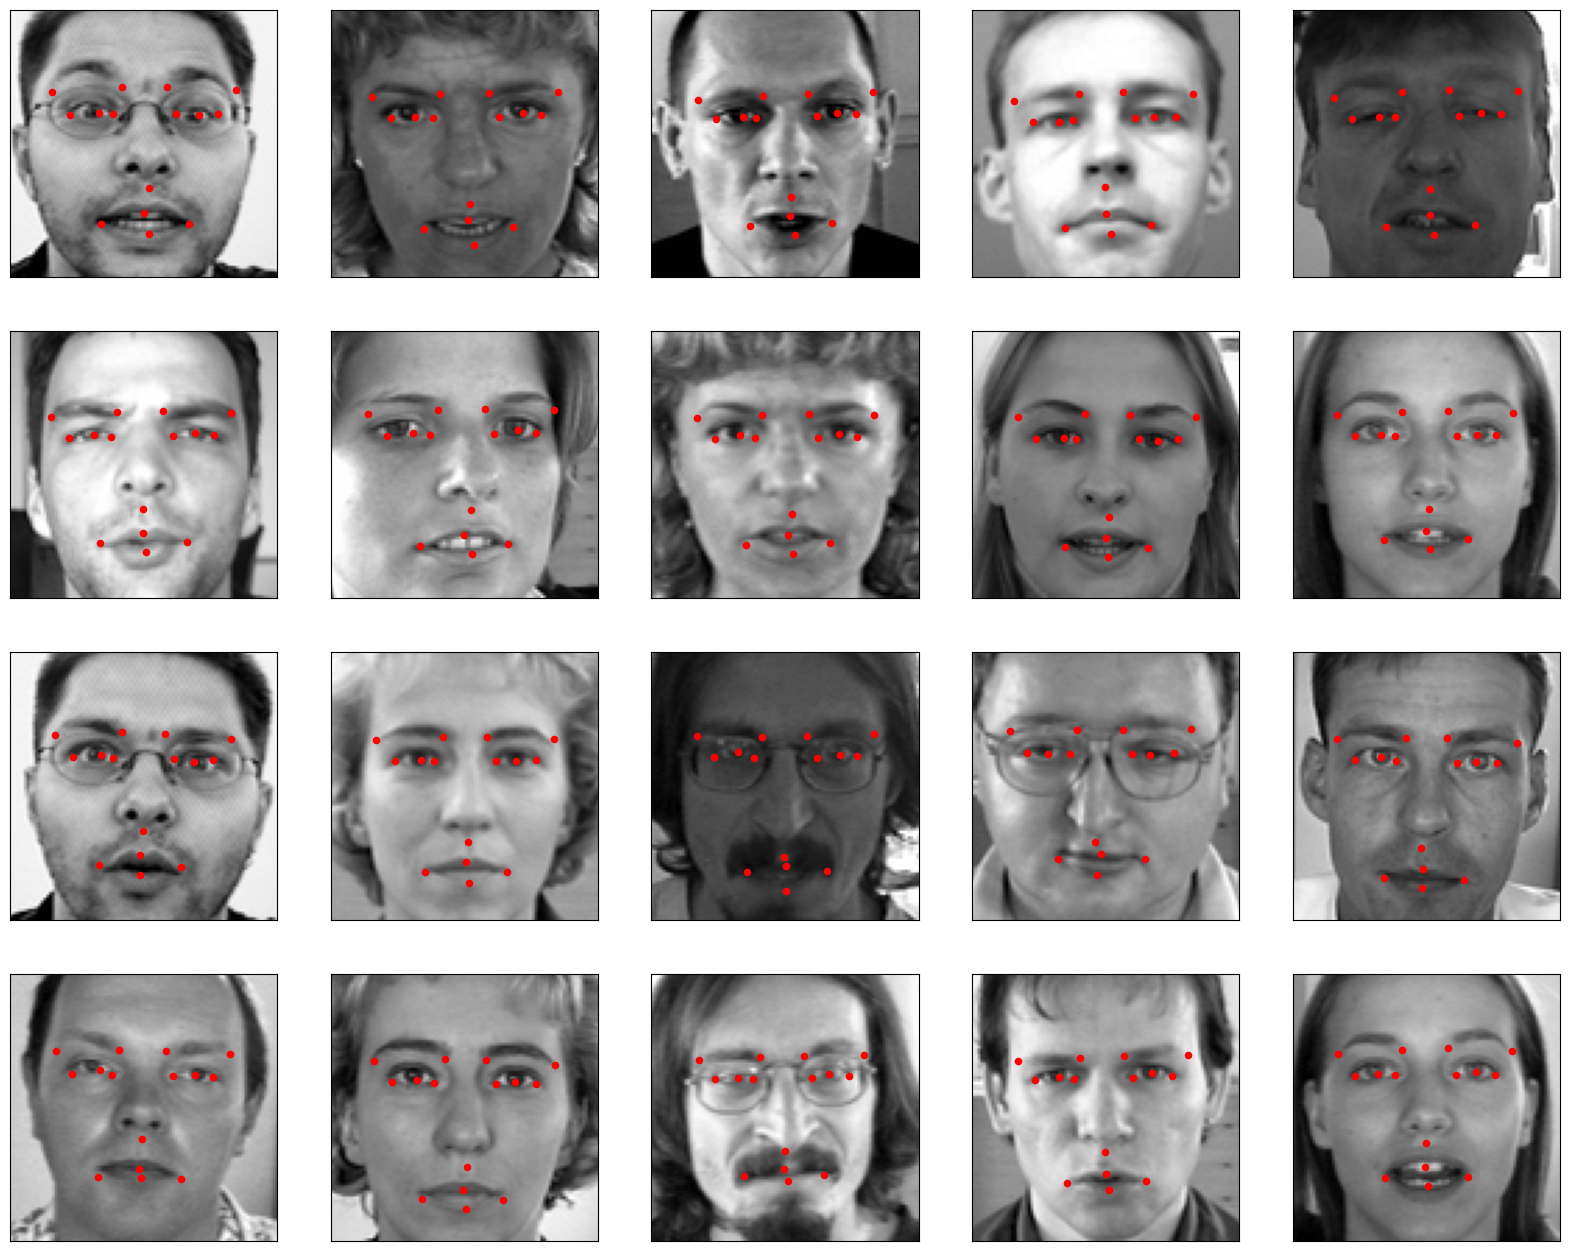

In [50]:
fig = plt.figure(figsize=(20,16))
for i in range(20):
    axis = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
    plot_sample(X_test_submit[i], predictions1[i], axis, "")
plt.show()

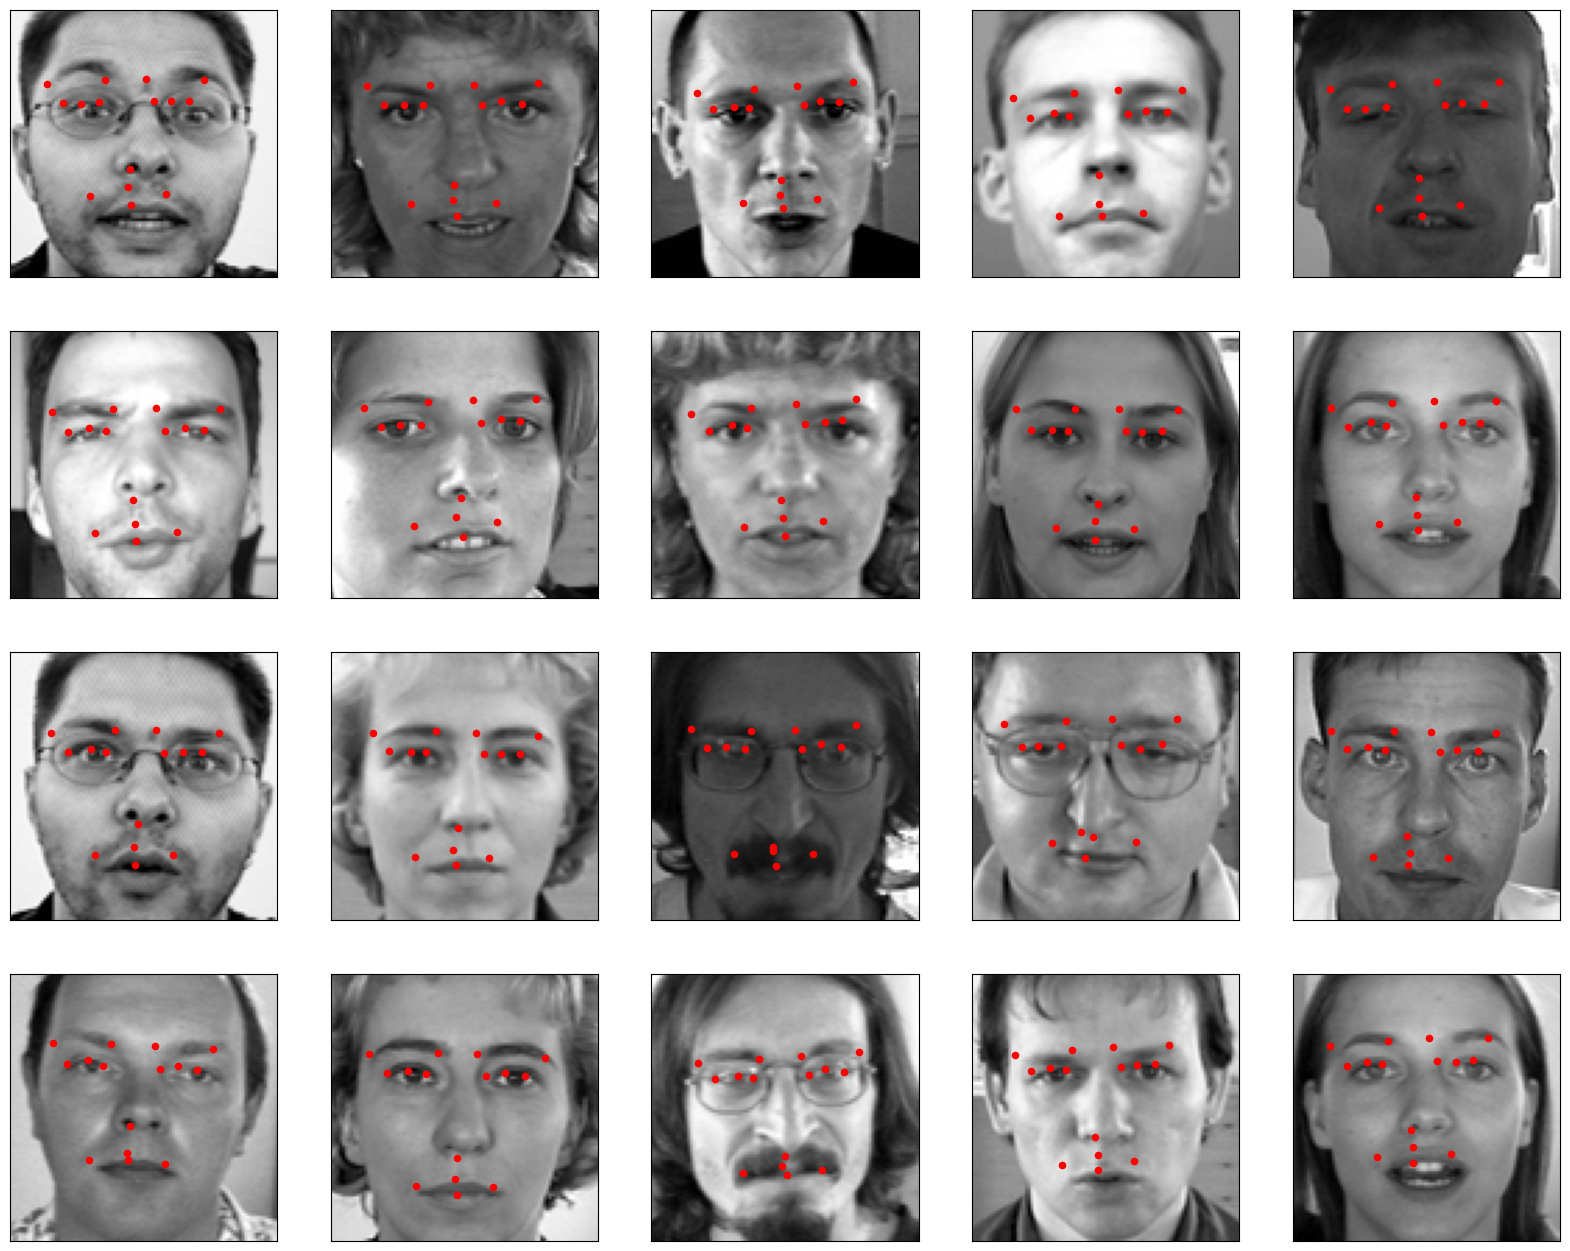

In [51]:
fig = plt.figure(figsize=(20,16))
for i in range(20):
    axis = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
    plot_sample(X_test_submit[i], predictions2[i], axis, "")
plt.show()

# Submitting predictions on test data

In [52]:
lookup = pd.read_csv('/kaggle/input/facial-keypoints-detection/IdLookupTable.csv')
lookup.head()

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN


In [53]:
feature = list(lookup['FeatureName'])
image_ids = list(lookup['ImageId']-1)
row_ids = lookup['RowId']
pre_list = list(predictions1)

feature_list = []
for f in feature:
    feature_list.append(feature.index(f))

final_preds = []
for x,y in zip(image_ids, feature_list):
    final_preds.append(pre_list[x][y])
    
row_ids = pd.Series(row_ids, name = 'RowId')
locations = pd.Series(final_preds, name = 'Location')
locations = locations.clip(0.0,96.0)

submission_result = pd.concat([row_ids,locations],axis = 1)
submission_result

,RowId,Location
0,1,67.299355
1,2,37.231594
2,3,31.580685
3,4,36.573074
4,5,59.078648
...,...,...
27119,27120,37.488411
27120,27121,47.691380
27121,27122,67.350433
27122,27123,47.499172


In [54]:
submission_result.to_csv('submission.csv',index = False)